<a href="https://colab.research.google.com/github/Gdias2701/Classificador_Explicavel_Pneumonia_SHAP/blob/main/Classificador_Explic%C3%A1vel_PNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install kaggle
import os
os.makedirs("/root/.kaggle", exist_ok=True)
from google.colab import files
files.upload()


!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray


In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import random

base_dir = "/content/chest_xray/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

img_size = (180, 180)
batch_size = 32


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:

def create_model(params):
    f1, f2, f3, dropout_rate, lr = params
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(int(f1), (3,3), activation='relu', input_shape=(180,180,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(int(f2), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(int(f3), (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(params):
    model = create_model(params)
    history = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

def abc_optimization(num_bees=5, iterations=5):

    param_bounds = {
        'f1': (16, 64),
        'f2': (32, 128),
        'f3': (64, 256),
        'dropout': (0.2, 0.5),
        'lr': (1e-4, 1e-2)
    }


    bees = []
    for _ in range(num_bees):
        bee = [
            random.uniform(*param_bounds['f1']),
            random.uniform(*param_bounds['f2']),
            random.uniform(*param_bounds['f3']),
            random.uniform(*param_bounds['dropout']),
            random.uniform(*param_bounds['lr'])
        ]
        bees.append(bee)

    best_bee = None
    best_score = 0

    for it in range(iterations):
        print(f"Iteração {it+1}/{iterations}")
        for i in range(num_bees):
            score = evaluate_model(bees[i])
            print(f"Bee {i+1} -> val_acc: {score:.4f}")
            if score > best_score:
                best_score = score
                best_bee = bees[i]


        for i in range(num_bees):
            bees[i] = [param + random.uniform(-0.1*param, 0.1*param) for param in bees[i]]

    print(f"\nMelhores hiperparâmetros encontrados: {best_bee}")
    print(f"Melhor acurácia de validação: {best_score:.4f}")
    return best_bee

best_params = abc_optimization(num_bees=2, iterations=3)


final_model = create_model(best_params)
final_model.fit(train_ds, validation_data=val_ds, epochs=5)
loss, acc = final_model.evaluate(test_ds)
print(f"Acurácia final no teste: {acc:.4%}")

Iteração 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.7270 - loss: 2.5148 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.8387 - loss: 0.4002 - val_accuracy: 0.8125 - val_loss: 0.5127
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.8478 - loss: 0.3712 - val_accuracy: 0.8750 - val_loss: 0.3857
Bee 1 -> val_acc: 0.8750
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.7841 - loss: 0.8427 - val_accuracy: 0.9375 - val_loss: 0.2328
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.9119 - loss: 0.2276 - val_accuracy: 0.8750 - val_loss: 0.3763
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.9592 - loss: 0.1056 - val_accuracy: 0.7500 - val_loss: 0.6147
Bee 2 -> val_acc: 0.7500
Iteração 2/3
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - accuracy: 0.7488 - loss: 1.7981 - val_accuracy: 0.5000 - val_loss: 1.6885
Epoch 2/3
163/163 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


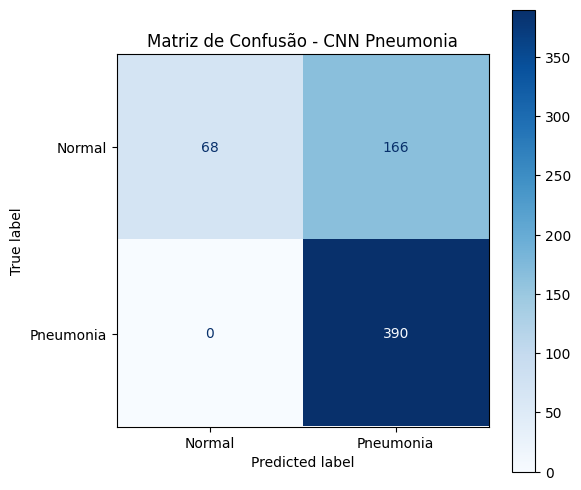

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model=final_model
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_classes = (preds > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes.squeeze())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de Confusão - CNN Pneumonia")
plt.show()


In [6]:

for images, labels in test_ds.take(1):
    X_test = images.numpy()
    y_test = labels.numpy()


X_sample = X_test[:100]
y_sample = y_test[:100]


In [7]:
!pip install shap


In [8]:
import shap
import numpy as np


In [9]:

explainer = shap.GradientExplainer(model, X_sample)


shap_values = explainer.shap_values(X_sample)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_66
Received: inputs=['Tensor(shape=(32, 180, 180, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_66
Received: inputs=['Tensor(shape=(50, 180, 180, 3))']
  warnings.warn(msg)


In [10]:
import shap
import numpy as np


def predict_binary(img):
    out = model(img)
    out = np.concatenate([1-out, out], axis=1)
    return out


masker = shap.maskers.Image("blur(32,32)", X_sample[0].shape)

explainer = shap.Explainer(predict_binary, masker, output_names=['Normal', 'Pneumonia'])
shap_values = explainer(X_sample[0:1], max_evals=1000)


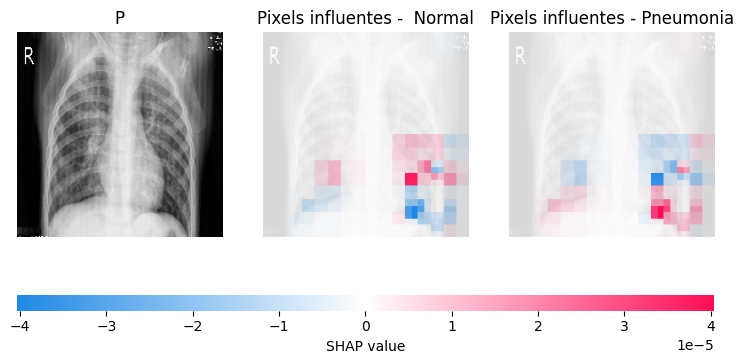

In [14]:

index = 28

img = np.expand_dims(X_sample[index], axis=0)


shap_values_img = explainer(img)

sv = shap_values_img.values[0]
sv = np.expand_dims(sv, axis=0)
shap_per_class = [sv[..., i] for i in range(2)]


sample_label = 'Pneumonia' if y_sample[index] == 1 else 'Normal'
class_labels = ['Pixels influentes -  Normal', 'Pixels influentes - Pneumonia']

shap.image_plot(
    shap_values=shap_per_class,
    pixel_values=img,
    labels=class_labels,
    true_labels= sample_label,
)

plt.show()
